In [78]:
#importamos librerías necesarias y generamos dataframe a partir de los datos
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import json
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime
from meteostat import Point, Daily
import patoolib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


#generamos dataframe
gun_weather = pd.read_csv('C:\coderhouse\coderhouse\proyecto_final\gun_violence_full.csv')

In [79]:
gun_weather_ill = gun_weather[gun_weather.city_or_county == "Rockford"]
gun_weather_alg = gun_weather_ill[['date', 'incident_amount']]
gun_weather_day = gun_weather_alg.groupby('date').sum()
gun_weather_day.index = gun_weather_day.index.astype("datetime64[ns]")

In [80]:
def setweather(_from, _to):
    #time period
    start = datetime(_from, 1, 1)
    end = datetime(_to, 12, 31)
    
    #location point
    location = Point(gun_weather_ill["latitude"].mean(), gun_weather_ill["longitude"].mean())

    # Get daily data 
    data = Daily(location, start, end)
    data = data.fetch()
    return data

In [81]:
w_data = setweather(2014, 2016)
w_data.index = w_data.index.astype("datetime64[ns]")
gun_alg = w_data.join(gun_weather_day)
gun_alg['incident_amount'].fillna('False', inplace=True)
gun_alg.loc[gun_alg["incident_amount"] != "False", "incident_amount"] = True
gun_alg = gun_alg.drop(['tsun', 'wpgt', 'wdir'], axis=1)
gun_alg['pres'] = gun_alg['pres'].fillna(gun_alg['pres'].median())
gun_alg['day'] = gun_alg.index.day
gun_alg['month'] = gun_alg.index.month
gun_alg['day_of_the_week'] = gun_alg.index.dayofweek
gun_alg.rename(columns = {'incident_amount':'incident'}, inplace = True)


In [82]:
gun_alg.head()

,tavg,tmin,tmax,prcp,snow,wspd,pres,incident,day,month,day_of_the_week
time,,,,,,,,,,,
2014-01-01,-12.4,-13.8,-8.8,5.8,230.0,22.7,1026.7,True,1,1,2
2014-01-02,-12.1,-23.8,-10.5,0.0,280.0,19.4,1027.7,False,2,1,3
2014-01-03,-18.7,-27.7,-7.1,0.0,280.0,21.2,1025.4,True,3,1,4
2014-01-04,-5.2,-7.1,-1.6,4.8,280.0,18.4,1012.5,False,4,1,5
2014-01-05,-8.8,-21.6,-6.6,0.0,330.0,30.2,1020.2,False,5,1,6


In [83]:
w_data = setweather(2017, 2017)
w_data.index = w_data.index.astype("datetime64[ns]")
gun_val = w_data.join(gun_weather_day)
gun_val['incident_amount'].fillna('False', inplace=True)
gun_val.loc[gun_val["incident_amount"] != "False", "incident_amount"] = True
gun_val = gun_val.drop(['tsun', 'wpgt', 'wdir'], axis=1)
gun_val['pres'] = gun_val['pres'].fillna(gun_val['pres'].median())
gun_val['day'] = gun_val.index.day
gun_val['month'] = gun_val.index.month
gun_val['day_of_the_week'] = gun_val.index.dayofweek
gun_val.rename(columns = {'incident_amount':'incident'}, inplace = True)

In [84]:
gun_val.head()

,tavg,tmin,tmax,prcp,snow,wspd,pres,incident,day,month,day_of_the_week
time,,,,,,,,,,,
2017-01-01,-3.4,-8.8,3.9,0.0,0.0,9.4,1020.1,True,1,1,6
2017-01-02,0.9,-4.3,5.0,0.0,0.0,11.5,1017.6,False,2,1,0
2017-01-03,2.6,-10.5,3.3,0.0,0.0,19.1,1012.0,False,3,1,1
2017-01-04,-10.2,-14.3,-8.2,0.0,0.0,27.7,1019.6,True,4,1,2
2017-01-05,-13.1,-17.1,-9.9,0.0,0.0,20.5,1020.2,True,5,1,3


In [85]:
#armando matriz de correlacion y transformándola a tidy

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)


gun_alg_aux = gun_alg
corr_matrix = gun_alg_aux.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10000)

,variable_1,variable_2,r,abs_r
1,tavg,tmin,0.980836,0.980836
10,tmin,tavg,0.980836,0.980836
2,tavg,tmax,0.979097,0.979097
20,tmax,tavg,0.979097,0.979097
21,tmax,tmin,0.946572,0.946572
...,...,...,...,...
98,day_of_the_week,month,-0.006627,0.006627
79,day,day_of_the_week,0.003712,0.003712
97,day_of_the_week,day,0.003712,0.003712
9,tavg,day_of_the_week,-0.001765,0.001765


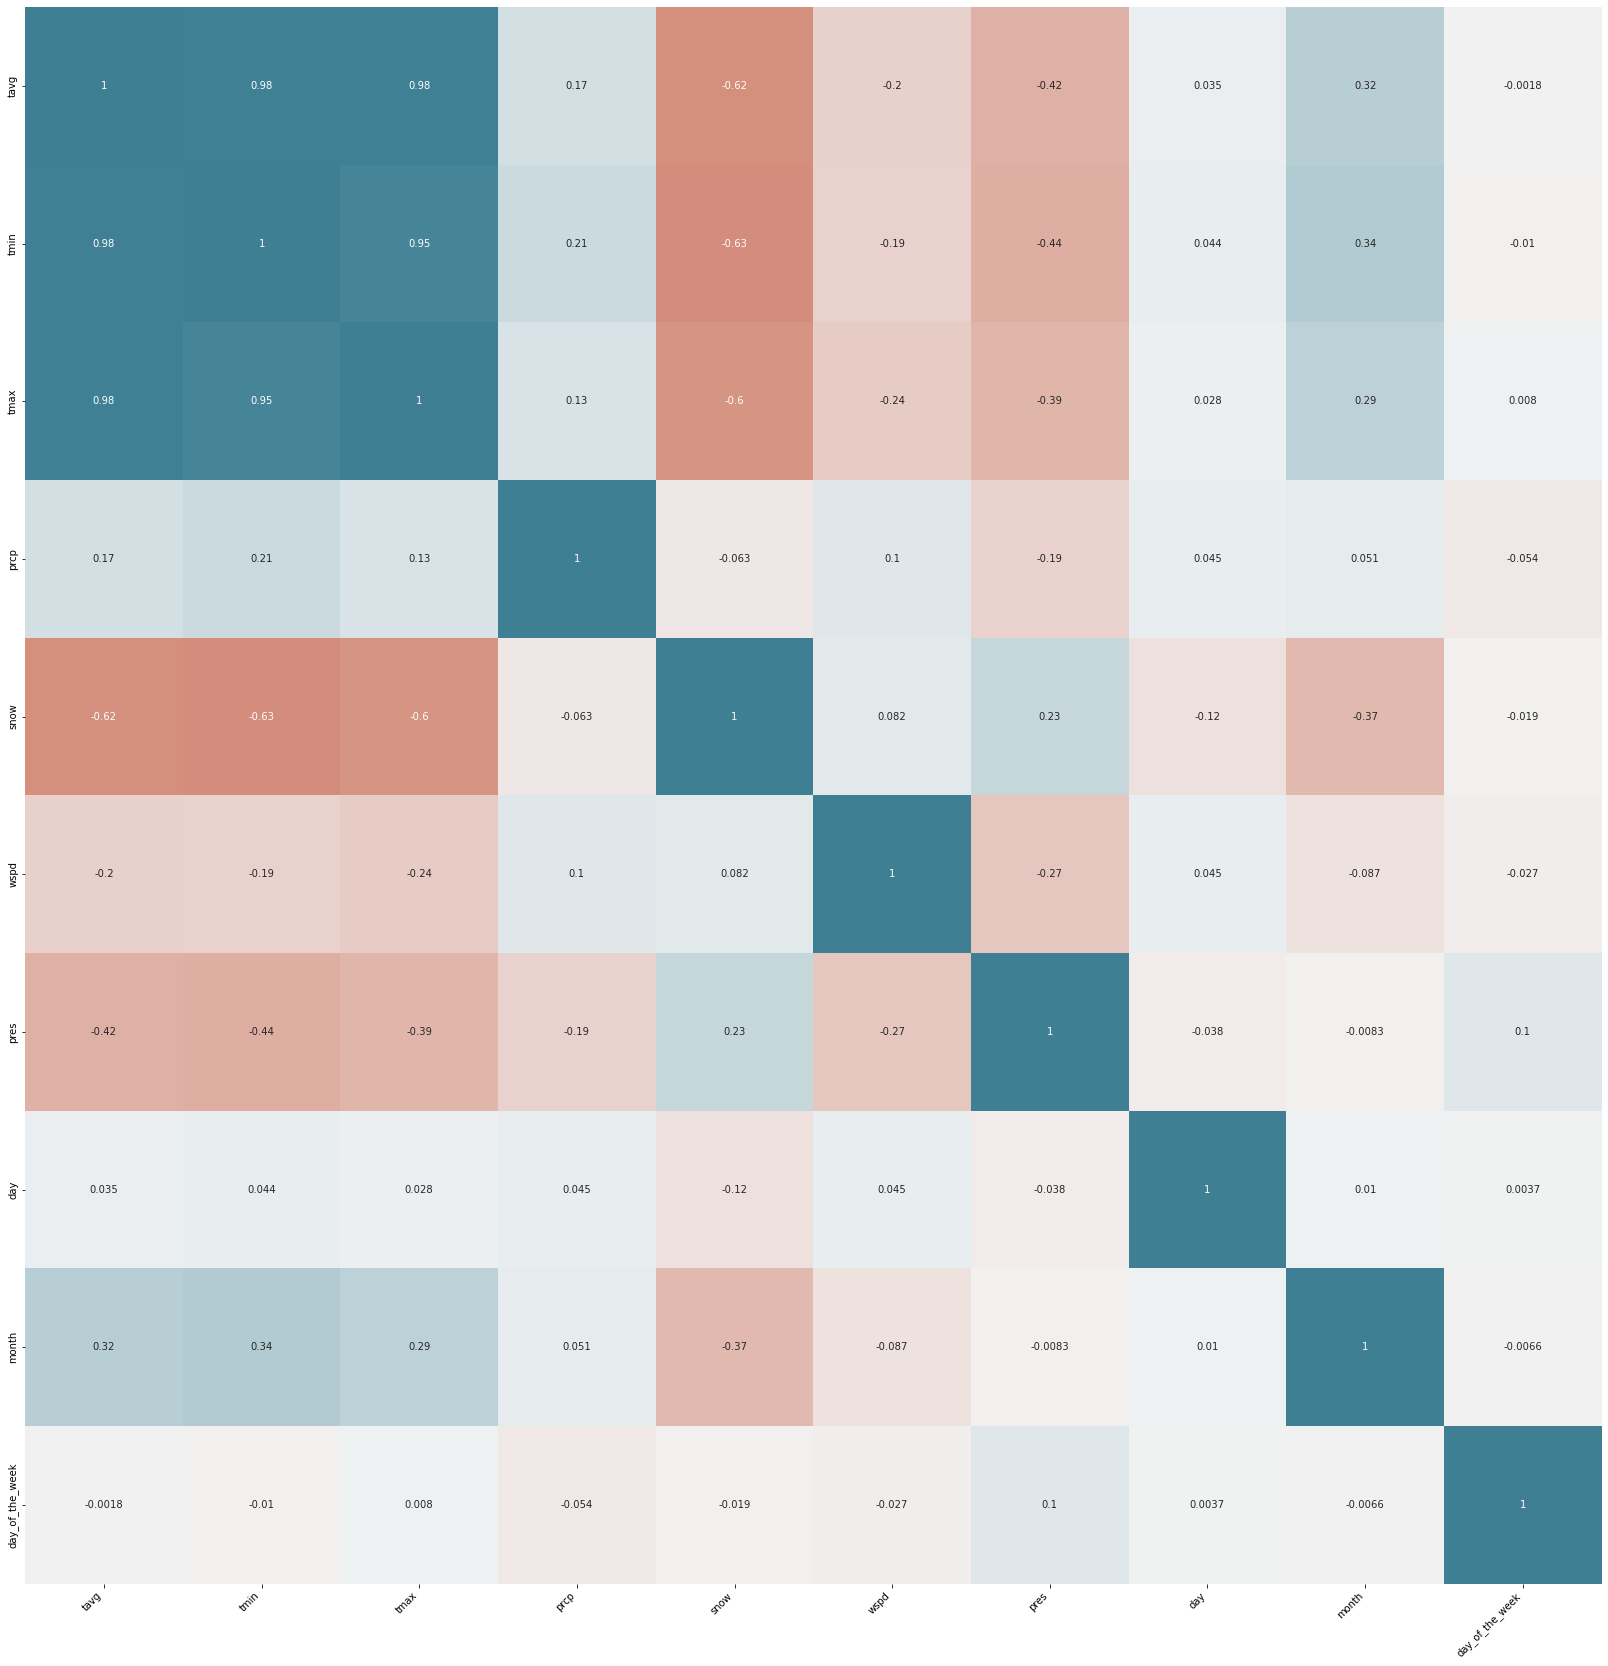

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(29, 29))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [87]:
gun_alg_aux['incident'] = pd.factorize(gun_alg_aux['incident'])[0]

In [88]:
gun_alg

,tavg,tmin,tmax,prcp,snow,wspd,pres,incident,day,month,day_of_the_week
time,,,,,,,,,,,
2014-01-01,-12.4,-13.8,-8.8,5.8,230.0,22.7,1026.7,0,1,1,2
2014-01-02,-12.1,-23.8,-10.5,0.0,280.0,19.4,1027.7,1,2,1,3
2014-01-03,-18.7,-27.7,-7.1,0.0,280.0,21.2,1025.4,0,3,1,4
2014-01-04,-5.2,-7.1,-1.6,4.8,280.0,18.4,1012.5,1,4,1,5
2014-01-05,-8.8,-21.6,-6.6,0.0,330.0,30.2,1020.2,1,5,1,6
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,-2.9,-7.1,-1.0,0.0,0.0,16.6,1021.5,0,27,12,1
2016-12-28,-1.7,-7.1,6.1,0.0,0.0,15.5,1017.5,1,28,12,2
2016-12-29,0.5,-1.6,1.7,0.0,0.0,28.8,1017.5,1,29,12,3


In [89]:
gun_alg_aux

,tavg,tmin,tmax,prcp,snow,wspd,pres,incident,day,month,day_of_the_week
time,,,,,,,,,,,
2014-01-01,-12.4,-13.8,-8.8,5.8,230.0,22.7,1026.7,0,1,1,2
2014-01-02,-12.1,-23.8,-10.5,0.0,280.0,19.4,1027.7,1,2,1,3
2014-01-03,-18.7,-27.7,-7.1,0.0,280.0,21.2,1025.4,0,3,1,4
2014-01-04,-5.2,-7.1,-1.6,4.8,280.0,18.4,1012.5,1,4,1,5
2014-01-05,-8.8,-21.6,-6.6,0.0,330.0,30.2,1020.2,1,5,1,6
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,-2.9,-7.1,-1.0,0.0,0.0,16.6,1021.5,0,27,12,1
2016-12-28,-1.7,-7.1,6.1,0.0,0.0,15.5,1017.5,1,28,12,2
2016-12-29,0.5,-1.6,1.7,0.0,0.0,28.8,1017.5,1,29,12,3


            Actual  Predicted
time                         
2016-11-28       0        1.0
2014-01-28       1        1.0
2015-12-20       1        1.0
2015-05-07       1        1.0
2014-07-16       1        1.0
...            ...        ...
2016-01-31       0        0.0
2015-10-19       0        1.0
2016-02-04       1        1.0
2015-12-04       0        1.0
2016-09-17       1        1.0

[220 rows x 2 columns]
Accuracy: 0.6818181818181818
precision score 0.5042016806722689
R2 Score:-0.5569709837225763
MAE:0.3181818181818182


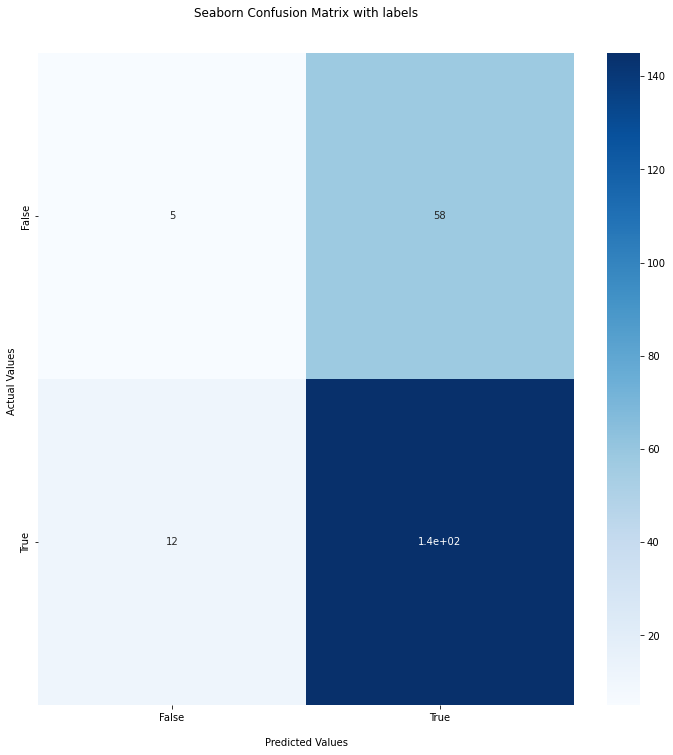

In [90]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Entrenamiento del modelo Random Forest Regressor

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

#Realizando las predicciones
y_pred = regressor.predict(X_test).round(0)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)


#Con nuestro modelo
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

#matriz de confusión del modelo
fig, ax = plt.subplots(figsize=(12, 12))
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


            Actual  Predicted
time                         
2016-11-28       0          1
2014-01-28       1          1
2015-12-20       1          1
2015-05-07       1          1
2014-07-16       1          1
...            ...        ...
2016-01-31       0          1
2015-10-19       0          1
2016-02-04       1          1
2015-12-04       0          1
2016-09-17       1          1

[220 rows x 2 columns]
Accuracy: 0.7136363636363636
precision score 0.3568181818181818
R2 Score:-0.4012738853503186
MAE:0.2863636363636364


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


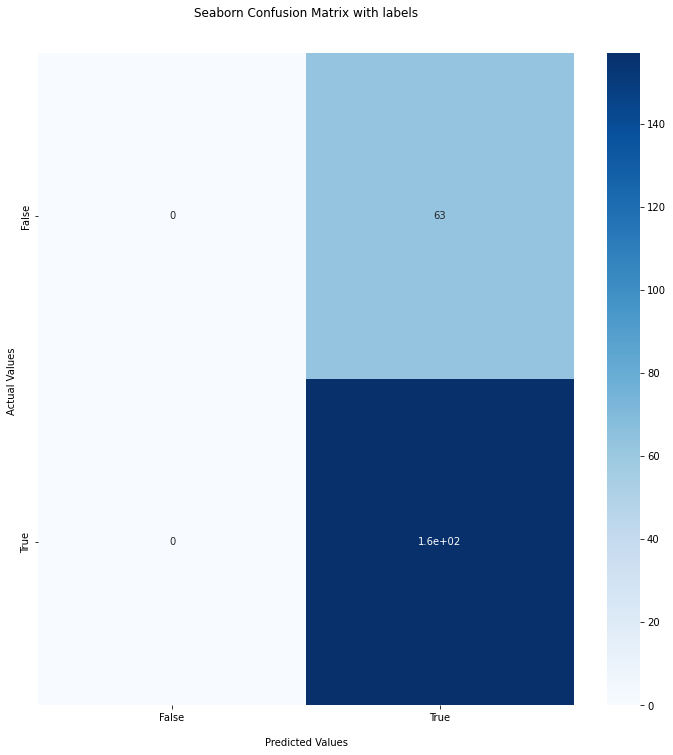

In [91]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#Entrenando modelo de Regresión Logística
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro')) 
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

#matriz de confusión del modelo
fig, ax = plt.subplots(figsize=(12, 12))
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


            Actual  Predicted
time                         
2016-10-28       1          1
2014-04-02       1          1
2015-06-25       0          1
2014-03-09       0          0
2014-10-21       0          1
...            ...        ...
2016-06-02       1          1
2016-04-08       0          1
2015-12-19       1          1
2015-12-09       1          1
2016-03-09       1          1

[220 rows x 2 columns]
Accuracy: 0.65
precision score 0.5622170754816296
R2 Score:-0.7292772560228669
MAE:0.35


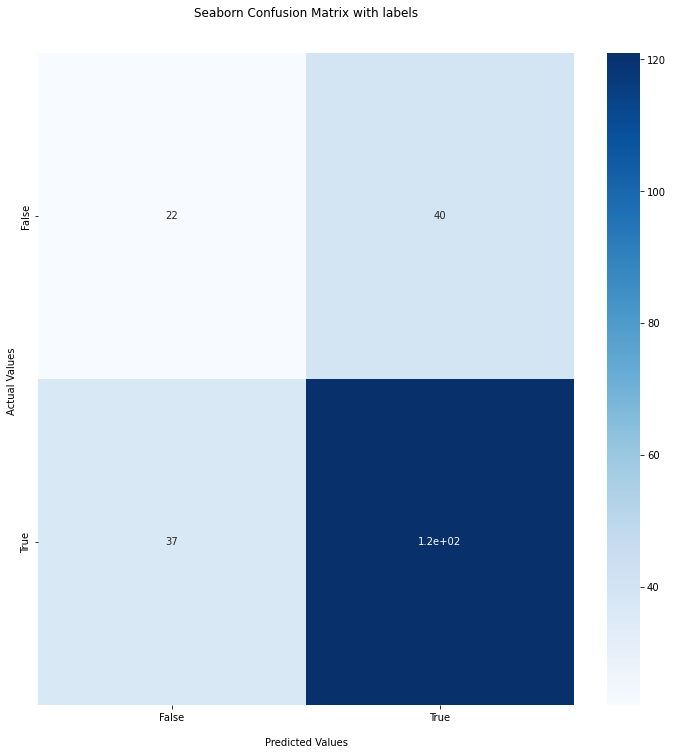

In [92]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


#Entrenando Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)


df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

#matriz de confusión del modelo
fig, ax = plt.subplots(figsize=(12, 12))
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


            Actual  Predicted
time                         
2016-10-28       1          1
2014-04-02       1          1
2015-06-25       0          1
2014-03-09       0          1
2014-10-21       0          1
...            ...        ...
2016-06-02       1          1
2016-04-08       0          1
2015-12-19       1          1
2015-12-09       1          1
2016-03-09       1          1

[220 rows x 2 columns]
Accuracy: 0.6818181818181818
precision score 0.51
R2 Score:-0.5720702327480609
MAE:0.3181818181818182


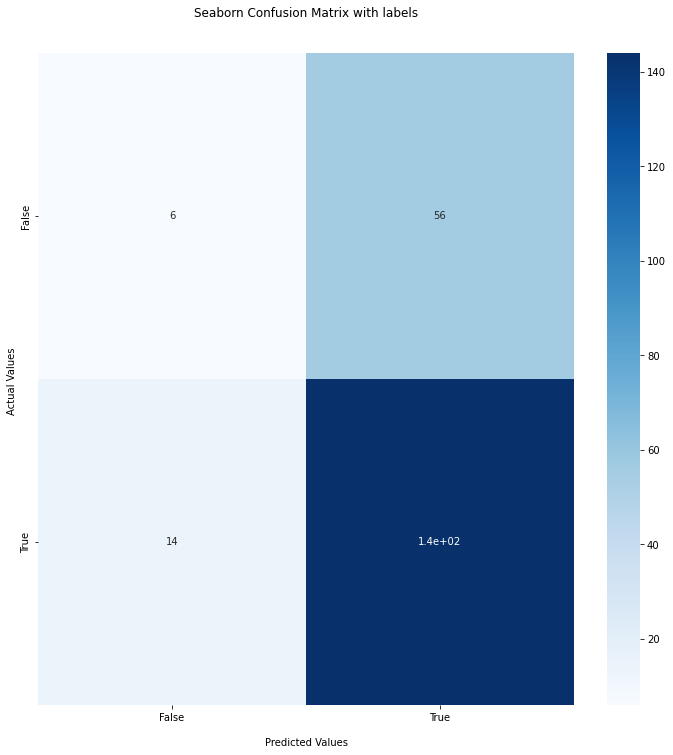

In [93]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#entrenando Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

#matriz de confusión del modelo
fig, ax = plt.subplots(figsize=(12, 12))
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

            Actual  Predicted
time                         
2016-10-28       1          1
2014-04-02       1          1
2015-06-25       0          1
2014-03-09       0          1
2014-10-21       0          1
...            ...        ...
2016-06-02       1          1
2016-04-08       0          1
2015-12-19       1          1
2015-12-09       1          1
2016-03-09       1          1

[220 rows x 2 columns]
Accuracy: 0.7181818181818181
precision score 0.35909090909090907
R2 Score:-0.39240506329113956
MAE:0.2818181818181818


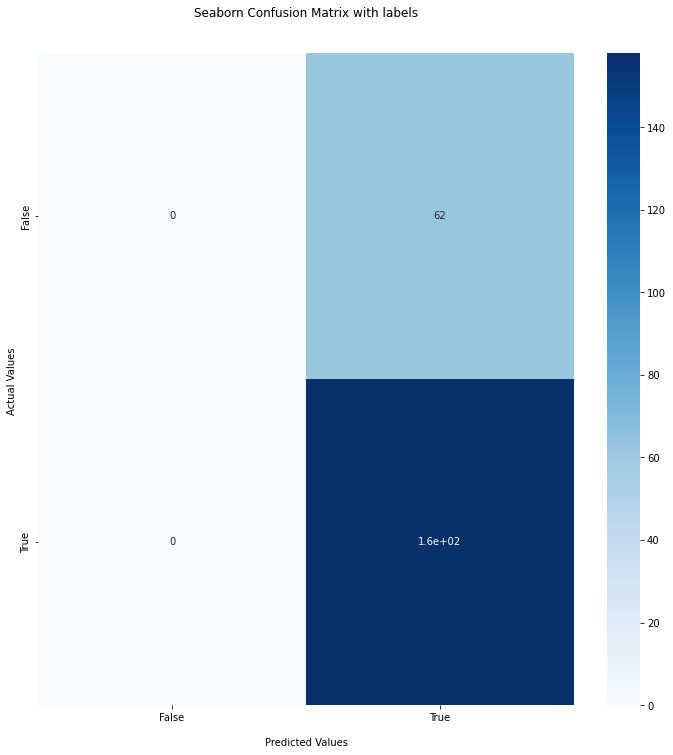

In [94]:

#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#entrenando algoritmo maquina de soporte de vectores

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

#matriz de confusión del modelo
fig, ax = plt.subplots(figsize=(12, 12))
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

            Actual  Predicted
time                         
2016-10-28       1          1
2014-04-02       1          1
2015-06-25       0          0
2014-03-09       0          1
2014-10-21       0          1
...            ...        ...
2016-06-02       1          1
2016-04-08       0          1
2015-12-19       1          1
2015-12-09       1          1
2016-03-09       1          1

[220 rows x 2 columns]
Accuracy: 0.6954545454545454
precision score 0.5547977985163914
R2 Score:-0.5046957942017154
MAE:0.30454545454545456


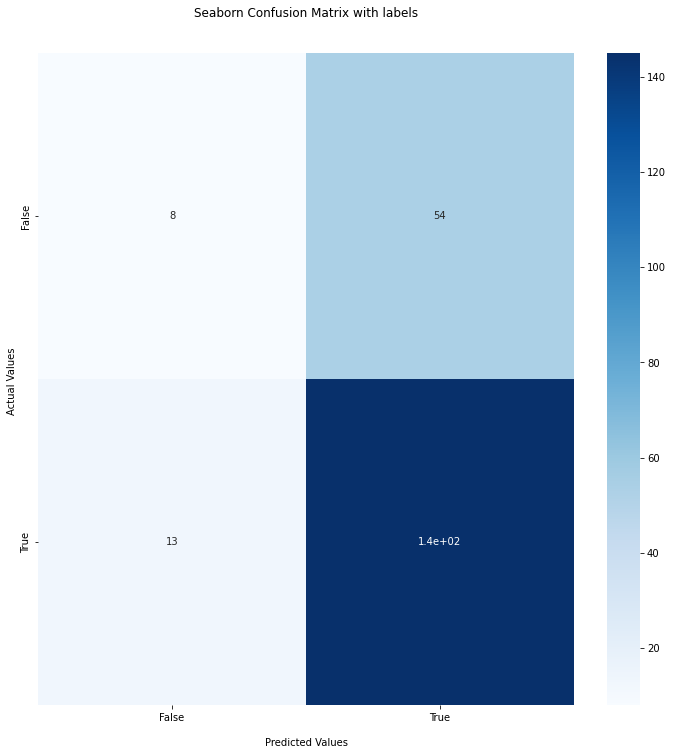

In [95]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


#entrenando algoritmo Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

#matriz de confusión del modelo
fig, ax = plt.subplots(figsize=(12, 12))
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()